# Lab 4: Gaussian Mixture Models
Related lecture: https://ucmercedcse176.github.io/files/lecture_6.pdf

Note on GMM: https://ucmercedcse176.github.io/files/GMM.pdf

Some materials from Marc Deisenroth

In this notebook, we will look at density modeling with Gaussian mixture models (GMMs).
In Gaussian mixture models, we describe the density of the data as
$$
p(\boldsymbol x) = \sum_{k=1}^K \pi_k \mathscr{N}(\boldsymbol x|\boldsymbol \mu_k, \boldsymbol \Sigma_k)\,,\quad \pi_k \geq 0\,,\quad \sum_{k=1}^K\pi_k = 1
$$

The goal of this notebook is to get a better understanding of GMMs and to write some code for training GMMs using the EM algorithm. We provide a code skeleton and mark the bits and pieces that you need to implement yourself.

In [1]:
# imports
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import scipy.linalg as la
import matplotlib.cm as cm
from matplotlib import rc
import time
from IPython import display

%matplotlib inline

np.random.seed(42)

### Define a GMM from which we generate data
Set up the true GMM from which we will generate data.

In [2]:
# Choose a GMM with 3 components

# means
m = np.zeros((3,2))
m[0] = np.array([1.2, 0.4])
m[1] = np.array([-4.4, 1.0])
m[2] = np.array([4.1, -0.3])

# covariances
S = np.zeros((3,2,2))
S[0] = np.array([[0.8, -0.4], [-0.4, 1.0]])
S[1] = np.array([[1.2, -0.8], [-0.8, 1.0]])
S[2] = np.array([[1.2, 0.6], [0.6, 3.0]])

# mixture weights
w = np.array([0.3, 0.2, 0.5])

Generate some data

In [3]:
N = 600 # total number of data points
N_split = (N*w).astype(int) # number of data points per mixture component
x = []
y = []
for k in range(3):
    x_tmp, y_tmp = np.random.multivariate_normal(m[k], S[k], N_split[k]).T
    x = np.hstack([x, x_tmp])
    y = np.hstack([y, y_tmp])

data = np.vstack([x, y])

Visualization of the dataset

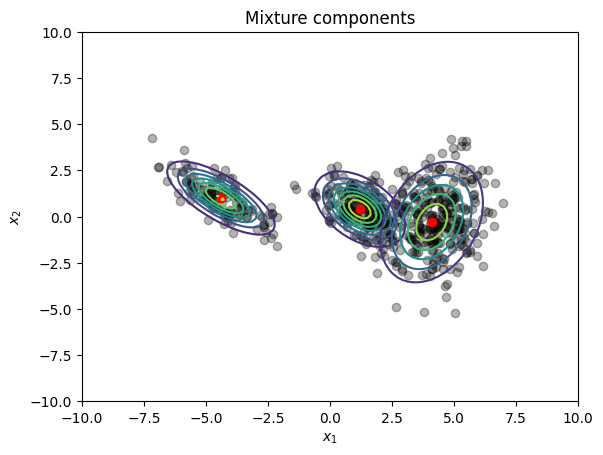

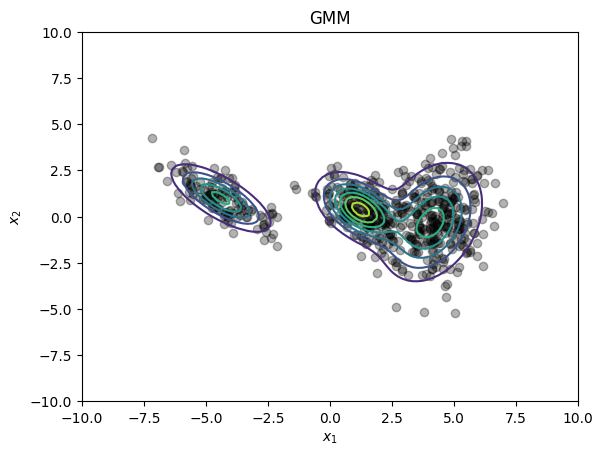

In [4]:
# plot the dataset
plt.figure()
plt.title("Mixture components")
plt.plot(x, y, 'ko', alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# plot the individual components of the GMM
plt.plot(m[:,0], m[:,1], 'or')

X, Y = np.meshgrid(np.linspace(-10,10,100), np.linspace(-10,10,100))
pos = np.dstack((X, Y))

for k in range(3):
    mvn = multivariate_normal(m[k,:].ravel(), S[k,:,:])
    xx = mvn.pdf(pos)
    plt.contour(X, Y, xx,  alpha = 1.0, zorder=10)

# plot the GMM
plt.figure()
plt.title("GMM")
plt.plot(x, y, 'ko', alpha=0.3)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

# build the GMM
gmm = 0
for k in range(3):
    mix_comp = multivariate_normal(m[k,:].ravel(), S[k,:,:])
    gmm += w[k]*mix_comp.pdf(pos)

plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10);

## Train the GMM via EM
### Initialize the parameters for EM

In [5]:
K = 3 # number of clusters

means = np.zeros((K,2))
covs = np.zeros((K,2,2))
for k in range(K):
    means[k] = np.random.normal(size=(2,))
    covs[k] = np.eye(2)

weights = np.ones((K,1))/K
print("Initial mean vectors (one per row):\n" + str(means))
print("Initial covariance matrices:\n" + str(covs))

Initial mean vectors (one per row):
[[ 0.1252245  -0.42940554]
 [ 0.1222975   0.54329803]
 [ 0.04886007  0.04059169]]
Initial covariance matrices:
[[[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]

 [[1. 0.]
  [0. 1.]]]


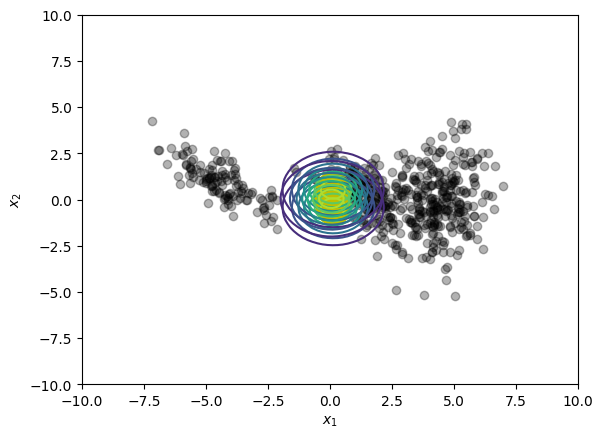

In [6]:
#EDIT THIS FUNCTION
NLL = [] # negative log-likelihood of the GMM
gmm_nll = 0
for k in range(K):
  # this is the micture density K functions
    gmm_nll += weights[k] * multivariate_normal.pdf(data.T, mean=means[k], cov=covs[k]) #<-- REPLACE THIS LINE
NLL += [-np.sum(np.log(gmm_nll))] #<-- REPLACE THIS LINE

plt.figure()
plt.plot(x, y, 'ko', alpha=0.3)
plt.plot(means[:,0], means[:,1], 'oy', markersize=25)

for k in range(K):
    rv = multivariate_normal(means[k,:], covs[k,:,:])
    plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)

plt.xlabel("$x_1$");
plt.ylabel("$x_2$");

First, we define the responsibilities (which are updated in the E-step), given the model parameters $\pi_k, \boldsymbol\mu_k, \boldsymbol\Sigma_k$ as

$$
r_{nk} := \frac{\pi_k\mathscr N(\boldsymbol
          x_n|\boldsymbol\mu_k,\boldsymbol\Sigma_k)}{\sum_{j=1}^K\pi_j\mathscr N(\boldsymbol
          x_n|\boldsymbol \mu_j,\boldsymbol\Sigma_j)}
          $$

Given the responsibilities we just defined, we can update the model parameters in the M-step as follows:
\begin{align*}
\boldsymbol\mu_k^\text{new} &= \frac{1}{N_k}\sum_{n = 1}^Nr_{nk}\boldsymbol x_n\,,\\
   \boldsymbol\Sigma_k^\text{new}&= \frac{1}{N_k}\sum_{n=1}^Nr_{nk}(\boldsymbol x_n-\boldsymbol\mu_k)(\boldsymbol x_n-\boldsymbol\mu_k)^\top\,,\\
   \pi_k^\text{new} &= \frac{N_k}{N}
\end{align*}
where $$
N_k := \sum_{n=1}^N r_{nk}
$$

### EM Algorithm

In [7]:
#EDIT THIS FUNCTION
r = np.zeros((K,N)) # will store the responsibilities

for em_iter in range(100):
    means_old = means.copy()

     # E-step: update responsibilities
    for k in range(K):
    # this is the micture density K functions
      r[k] = weights[k] * multivariate_normal.pdf(data.T, mean=means_old[k], cov=covs[k]) #<-- REPLACE THIS LINE

    r_sum = np.sum(r,axis=0)
    r = r/r_sum


    # M-step
    N_k = np.sum(r, axis=1)

    for k in range(K):
        # update the means
        means[k] = np.sum(r[k, :] * data, axis=1) / N_k[k]

        # update the covariances
        covs[k] = np.dot((r[k, :, np.newaxis] * (data.T - means[k])).T, data.T - means[k]) / N_k[k]

    # weights
    weights = N_k / N

    # negative log-likelihood
    gmm_nll = 0
    for k in range(K):
        gmm_nll += weights[k] * multivariate_normal.pdf(data.T, mean=means[k], cov=covs[k])
    NLL += [-np.sum(np.log(gmm_nll))]

    # plot the current state of the GMM
    plt.figure()
    plt.plot(x, y, 'ko', alpha=0.3)
    plt.plot(means[:,0], means[:,1], 'oy', markersize=25)
    for k in range(K):
        rv = multivariate_normal(means[k,:], covs[k])
        plt.contour(X, Y, rv.pdf(pos), alpha = 1.0, zorder=10)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.text(x=3.5, y=8, s="EM iteration "+str(em_iter+1))

    if la.norm(NLL[em_iter+1]-NLL[em_iter]) < 1e-6:
        print("Converged after iteration ", em_iter+1)
        break

# plot final the mixture model
plt.figure()
gmm = 0
for k in range(3):
    mix_comp = multivariate_normal(means[k,:].ravel(), covs[k,:,:])
    gmm += weights[k]*mix_comp.pdf(pos)

plt.plot(x, y, 'ko', alpha=0.3)
plt.contour(X, Y, gmm,  alpha = 1.0, zorder=10)
plt.xlim([-8,8]);
plt.ylim([-6,6]);

Output hidden; open in https://colab.research.google.com to view.

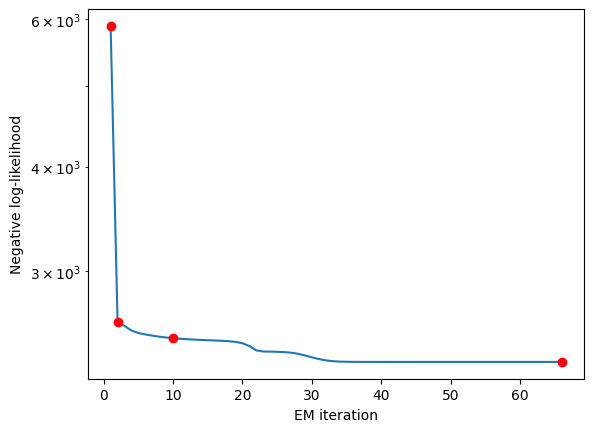

In [8]:
plt.figure()
plt.semilogy(np.linspace(1,len(NLL), len(NLL)), NLL)
plt.xlabel("EM iteration");
plt.ylabel("Negative log-likelihood");

idx = [0, 1, 9, em_iter+1]

for i in idx:
    plt.plot(i+1, NLL[i], 'or')